### 목표
 - 타이타닉 데이터를 활용하여 생존자/사망자 예측해보자
 - kaggle 경진대회에 참가하여 우리 점수를 확인해보자
 - 머신러닝의 전체 과정을 체험해보자
 
 #### 머신러닝 과정
  - 1. 문제정의 : 목표설정, 어떤 모델
  - 2. 데이터 수집 : 분류를 할거라면 class로 담긴 레이블이 있는 데이터 수집 같은
  - 3. 데이터 전처리 : 이상치/결측치 처리, 특성 처리(특성공학)
  - 4. 데이터 탐색(탐색전 데이터 분석) : 기술 통계, 특성 간의 관계
  - 5. 모델 선택 및 하이퍼 파라미터 설정
  - 6. 모델 예측 및 평가
  - 7. 모델 서비스화

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # 시각화 라이브러리
import seaborn as sns # 시각화 라이브러리
# train, test 분리하는 도구
from sklearn.model_selection import train_test_split
# 평가 도구
from sklearn.metrics import accuracy_score
# tree model - 사망/생존 이진분류
from sklearn.tree import DecisionTreeClassifier

In [2]:
# train , test 변수에 데이터 불러와서 담기
# 단, 인덱스를 승객의 번호로 설정해서 담아줄 것


In [3]:
train = pd.read_csv('./data/titanic/train.csv', index_col = 'PassengerId')
test = pd.read_csv('./data/titanic/test.csv', index_col = 'PassengerId')

train.head(3)
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# 크기 확인
print('트레인 크기:', train.shape)
print('테스트 크기:', test.shape) # test 정답 데이터 x (-1)

트레인 크기: (891, 11)
테스트 크기: (418, 10)


In [5]:
# 컬럼명만 뽑아서 확인하기
print(train.columns)
print(test.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


### 데이터 전처리 및 데이터 탐색
#### 결측치 확인

In [6]:
# info 함수 통해서 train 결측치 확인
train.info()
# 결측치 존재 컬럼 : Age, Cabin, Embarked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
# info 함수 통해서 test 결측치 확인
test.info()
# 결측치 존재 컬럼 : Age, Fare, Cabin

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [8]:
# 판다스 함수 통해서 test 결측치 확인
# 데이터 자리에 결측치가 있니? => 데이터.isnull()
test.isnull().sum()
# 결측치 존재 컬럼 : Age, Fare, Cabin
# 결측치(행)를 삭제하기 보다 채우면서 처리해보겠음

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

#### train-Embarked 결측치 처리
 - 승객이 탑승한 항구 이름

In [9]:
# train 데이터 기준으로 Embarked 컬럼 확인
train['Embarked'].unique()

# 빈도수가 높은 승선항 알파벳으로 결측치를 처리해보자
train['Embarked'].value_counts() # S 644 로 채워보자!

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
# test 안보나요?
# 탐색용 데이터는 train ,
# 모델 학습 : 모델이 학습을 잘하도록 데이터를 셋팅
# test 데이터는 모델을 일반화시키는데 도움이 되지 않음
# train 데이터가 학습할때 사용되고 모델의 일반화에 도움을 줌

In [11]:
# Embarked 결측치를 'S' 로 채우기
# fillna(채울값)
train['Embarked'] = train['Embarked'].fillna('S')
train['Embarked'].unique()
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
# 추가) Embarked 컬럼에 결측치가 있던 행의 정보를 확인하고
# 비슷한 사람의 데이터가 있다면 그 사람의 승선항 정보를 대체값으로 활용

#### test - Fare 결측치 처리
 - 요금 평균, 중앙값 계산 가능
 - 데이터 분석을 진행하면서 관련이 있을 법한 컬럼을 연관지어서 대체값을 확인해보자

In [13]:
# train 기준으로 데이터 탐색
# Fare 컬럼 정보 확인 -> 기술통계량
train['Fare'].describe()
# 요금의 대표값으로 평균보다 중앙이 더 나을 수 있겠음


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [14]:
# 변수(특성) 간의 상관관계 확인
# 상관계수(숫자) : -1 ~ 1
# 각 컬럼의 상관 정도를 수치로 표현한 값 : 상관계수
# -1, 1에 가까울수록 변수간의 관계성이 있음
# 0에 가까울수록 변수간의 관계성이 적음
# 생존 사망과 연관이 있는 컬럼 확인해보기
train.corr()['Survived'].abs()
# Pclass가 생존/사망 연관성이 있을 수 있겠음
# 등급에 따라 요금의 중앙값으로 채워주는 것도 의미가 있지 않을까?

C:\Users\newny\AppData\Local\Temp\ipykernel_14772\43214217.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['Survived'].abs()


Survived    1.000000
Pclass      0.338481
Age         0.077221
SibSp       0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [15]:
# 1. Pclass, Fare 두개 컬럼만 인덱싱해보기
# 2. Pclass 1,2,3 등급끼리 묶기(그룹화하기)
# 3. median() 집계함수 연결
train.loc[:,['Pclass', 'Fare']].groupby('Pclass').count()
# train.iloc[:,[1,8]].groupby('Pclass')
train.loc[:,['Pclass', 'Fare']].groupby('Pclass').median()

,Fare
Pclass,
1,60.2875
2,14.2500
3,8.0500


In [16]:
# test - Fare컬럼에 결측치가 있는 행 정보 출력하기
test[test['Fare'].isnull()]

# fillna() 를 활용해서 Fare 결측치 채워보기
# 3등급 -> 8.0500
# 1. test Fare 컬럼 접근
# 2. fillna() 사용해서 8.0500으로 채워보기
# 2번까지 했을 때 결측치가 없으면 test Fare 컬럼에 다시 초기화
test['Fare'] = test['Fare'].fillna(8.0500)
test[test['Fare'].isnull()] # 결측치 처리 완료 !

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


#### Age 컬럼 결측치 채우기 
 - 단순 기술 통계로만 채우지 않고, 다른 컬럼과의 상관관계를 이용해서 결측치를 채워보는 방향으로 진행해보자
 - Pclass, Sex 과 연관지어서 나이 통계 확인해보자

In [17]:
# train Age 컬럼 접근해서 기술 통계량 확인하기
train['Age'].describe()

# 평균, 중앙값의 큰 차이가 없음
# 평균치로 데이터를 처리해보자 

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [18]:
# 1 - 여성 - 나이 평균
# 1 - 남성 - 나이 평균
# 2 - 여성 - 나이 평균
# 2 - 남성 - 나이 평균
# 3 - 여성 - 나이 평균
# 3 - 남성 - 나이 평균
# 3개 - Pclass,age, Sex

gb1 = train[['Pclass', 'Age', 'Sex']].groupby(['Pclass', 'Sex']).mean()
gb1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [19]:
# gb1 
# 인덱스가 2개 => 멀티인덱스(중복인덱스) 
# 3, female 평균나이 데이터 접근해보기
gb1.loc[3,'female']

# 1, male 평균 나이 접근해보기

gb1.loc[(1,'male')]
# gb1.loc[(승객의 등급, 성별)]

Age    41.281386
Name: (1, male), dtype: float64

In [20]:
# 추가적으로 이해하는 코드
# numpy 널값 확인하는 함수
# Nan
# np.nan 결측치 표현
a = np.array([1,2, np.nan])
np.isnan(a[2])

True

In [21]:
# train, test 결측치
# train Age 컬럼의 결측치가 있는 해
# 1. Age 접근
# 2. null 확인
# 3. 불리언 인덱싱 적용 -> 행정보 출력됨
train[train['Age'].isnull()]

# 복잡한 처리를 해줄 수 있는 도구가 있나?
# 사용자 정의 함수 생성: Pclass, Sex 을 확인해서 gb1에 있는 평균나이로 대체
# 판다스 데이터랑 어떻게 연결? apply()
def fill_age(data) :
    # 만약 나이가 결측치라면 gb1에서 대체할 값을 가져오고 반환
    if np.isnan(data['Age']):
        gb1_age = gb1.loc[(data['Pclass'], data['Sex'])]
        return gb1_age
    # 결측치가 x 원래 나이 값을 반환
    else :
        return data['Age']
    
train['Age'] = train.apply(fill_age, axis = 1).astype('int64') # axis = 1 한사람의 대한 정보가 처리단위로 연결
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [22]:
# test Age 컬럼 결측치 처리하기
# gb1 - train
# test 결측치를 채울때 train(모델의 일반화 도움을 주는) 데이터를 기준으로 채워줌
test['Age'] = test.apply(fill_age, axis = 1).astype('int64')
test['Age'].isnull().sum() # 결측칯 처리 완료 확인 !
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


#### Cabin 컬럼 결측치 채우기

In [23]:
# train Cabin 컬럼 접근해보기
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [24]:
# 'M' 임의로 Cabin 결측치를 채워보기
# train, test
# fillna()
train['Cabin'].fillna('M', inplace = True)
test['Cabin'].fillna('M', inplace = True)
# 확인
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non

In [25]:
# train Cabin 접근해서 살펴보기
train['Cabin'][2][0]
# 판다스.str 해당 컬럼에 문자열 자료에 접근하는 키워드
train['Deck'] = train['Cabin'].str[0] # Deck 이라는 새로운 컬럼명 생성하여 저장
# test 도 실행해보기
test['Deck'] = test['Cabin'].str[0]

In [26]:
# Cabin 컬럼 삭제하기
# train, test
train = train.drop('Cabin', axis = 1)
# info() 확인
train.info()
test = test.drop('Cabin', axis = 1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 115.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 no

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 115.8+ KB


#### 데이터 탐색
 - train 데이터를 이용해서 탐색 진행함
 - test를 탐색하는 것은 모델의 일반화에 도움 안됨
 - Deck 컬럼이 생존/사망과 얼마나 연관이 있는지 확인해보기

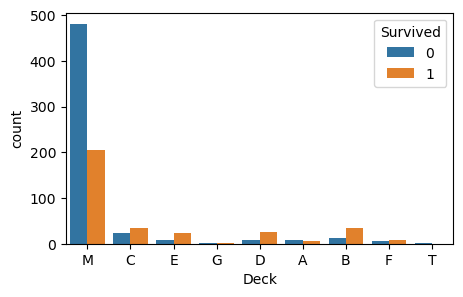

In [28]:
# x - Deck, y- Survived
plt.figure(figsize = (5, 3))
sns.countplot(data = train, x = 'Deck', hue = 'Survived')
plt.show()

- M에서 상대적으로 사람이 많이 사망했음
- Pclass와 Survived 컬럼의 관계확인(생존/사망 연관)

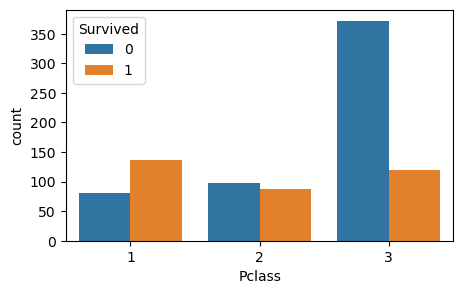

In [29]:
plt.figure(figsize = (5, 3)) # 그래프 사이즈 설정
sns.countplot(data = train, x = 'Pclass', hue = 'Survived')
plt.show()

- 승객의 등급이 높을 수록 비교적 생존율 높음
- 3등급의 승객들은 많이 사망함
- Deck과 Pclass 시각화

<Axes: xlabel='Deck', ylabel='count'>

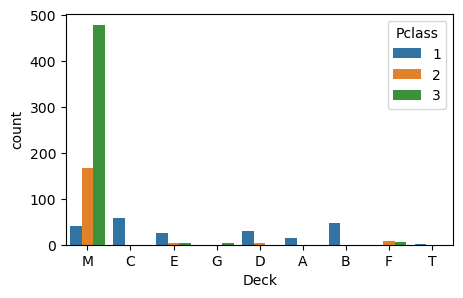

In [30]:
plt.figure(figsize = (5, 3))
sns.countplot(data = train, x = 'Deck', hue = 'Pclass')

- M(결측치)안에는 3등급의 사람들이 많아서 사망률이 높게 출력
- Sex과 Survived 관계 확인해보기

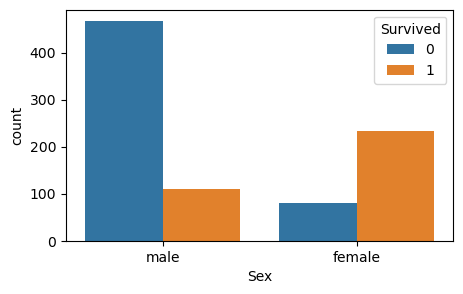

In [31]:
plt.figure(figsize = (5, 3))
sns.countplot(data = train, x = 'Sex', hue = 'Survived')
plt.show()

- male 사망율이 높음, female 비교적 생존율이 높음
- Embarked과 Survived 관계 확인해보기

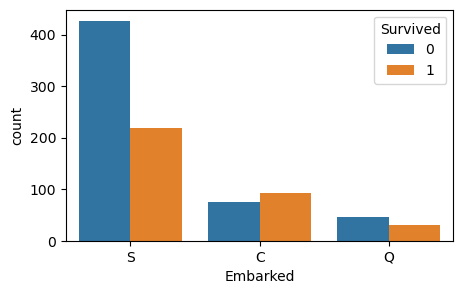

In [32]:
plt.figure(figsize = (5, 3))
sns.countplot(data = train, x = 'Embarked', hue = 'Survived')
plt.show()

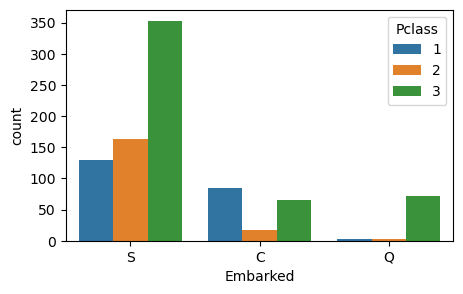

In [33]:
# Embarked 와 Pclass 관계
plt.figure(figsize = (5, 3))
sns.countplot(data = train, x = 'Embarked', hue = 'Pclass')
plt.show()

In [34]:
# Embared와 Pclass 관계 확인

- Age에 따른 생존/사망 시각화
 - 데이터의 분포를 확인할 때 여러가지 시각화 방법을 활용하는데, 그 중에 하나인 바이올린 플롯을 활용

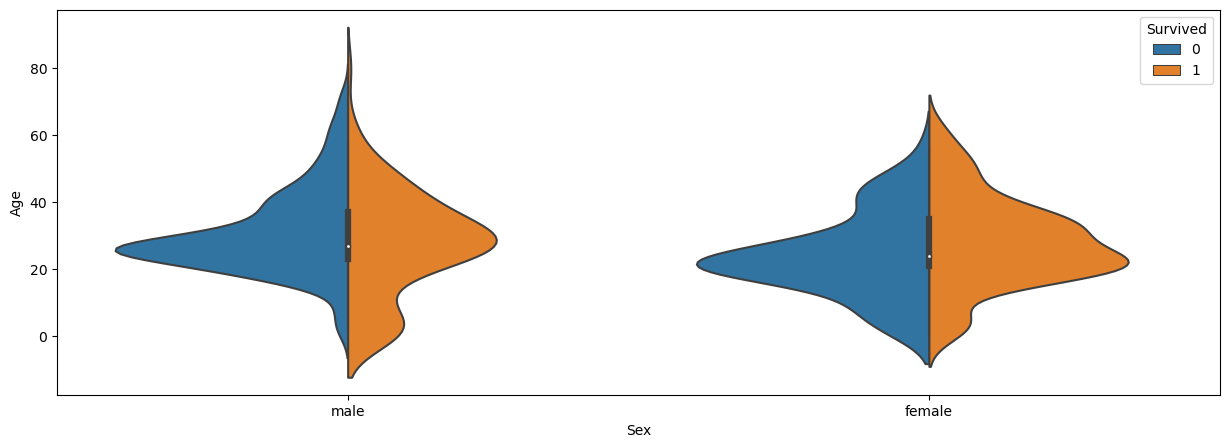

In [35]:
plt.figure(figsize = (15,5)) # x 15, y 5
sns.violinplot(data = train, x = 'Sex', y = 'Age', hue = 'Survived', split = True)
plt.show()

- 20~40대 사이에 사망이 많았음
- 어린아이 중에서는 남자아이가 여자아이에 비해 많이 생존했음
- Fare에 다른 생존/사망 시각화

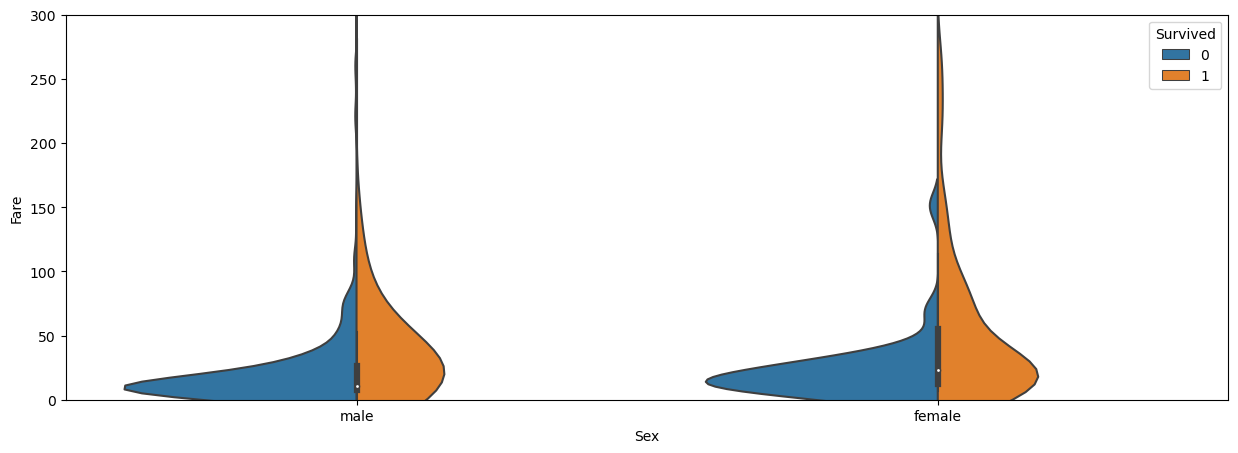

In [36]:
plt.figure(figsize = (15,5)) # x 15, y 5
sns.violinplot(data = train, x = 'Sex', y = 'Fare', hue = 'Survived', split = True)

# 0 ~ 300 y 축 범위 제한
plt.ylim(0,300)
plt.show()

In [37]:
# Fare 기술 통계량 확인
# train['Fare'].describe()

- 요금이 싼사람은 상대적으로 많이 사망함

In [38]:
# 컬럼명 확인
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Deck'],
      dtype='object')

#### 가족의 수 컬럼 생성
 - 기존을 가지고 새로운 컬럼을 생성(특성공학 분야중 1)
 - 가족의 수 : SibSp(형제자매, 배우자) + Parch(부모, 자식) + 1(자신)
 - train, test 두개 모두 컬럼 생성 진행

In [39]:
# SibSp + Parch + 1 => Family_Size 컬럼 추가 
# train, test
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1
train['Family_Size']

PassengerId
1      2
2      2
3      1
4      2
5      1
      ..
887    1
888    1
889    4
890    1
891    1
Name: Family_Size, Length: 891, dtype: int64

In [40]:
# test 에 Family_Size 컬럼 생성
test['Family_Size'] = test['SibSp'] + test['Parch'] + 1
test['Family_Size']

PassengerId
892     1
893     2
894     1
895     1
896     3
       ..
1305    1
1306    1
1307    1
1308    1
1309    3
Name: Family_Size, Length: 418, dtype: int64

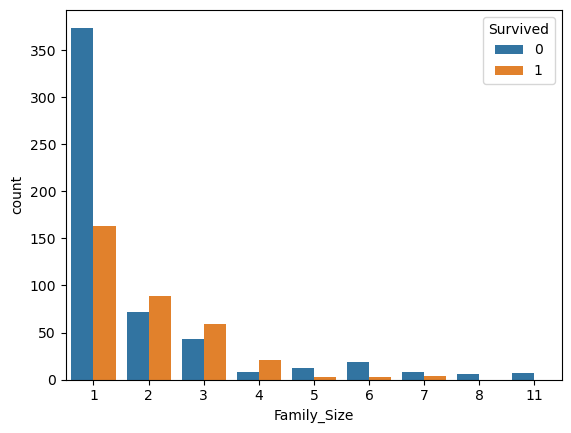

In [41]:
# 가족의 수 컬럼 이용해서 생존/사망 시각화
sns.countplot(data = train, x = 'Family_Size', hue = 'Survived')
plt.show()

- 1명 일때는 사망 비율이 높고, 2~4일때는 생존 비율이 높고, 5명 이상이면 사망 비율이 높음
- 사소한 관찰의 오류를 줄이기 위해서 범주를 줄여보자(binning)

In [42]:
# 가족의 수 1이면 Alone, 2~4명이면 Small, 5명이상이면 Large
# train, test 적용
# 연속적인 수치값을 범주화(카테고리화) 사용하는 pandas 함수 : pd.cut()
user_bins = [0,1,4,11] # 범위의 시작값은 포함되지 x
user_labels = ['Alone', 'Small', 'Large']
train['Family_Group'] = pd.cut(train['Family_Size'],
                               bins = user_bins, labels = user_labels)
test['Family_Group'] = pd.cut(test['Family_Size'],
                               bins = user_bins, labels = user_labels)
train['Family_Group']

PassengerId
1      Small
2      Small
3      Alone
4      Small
5      Alone
       ...  
887    Alone
888    Alone
889    Small
890    Alone
891    Alone
Name: Family_Group, Length: 891, dtype: category
Categories (3, object): ['Alone' < 'Small' < 'Large']

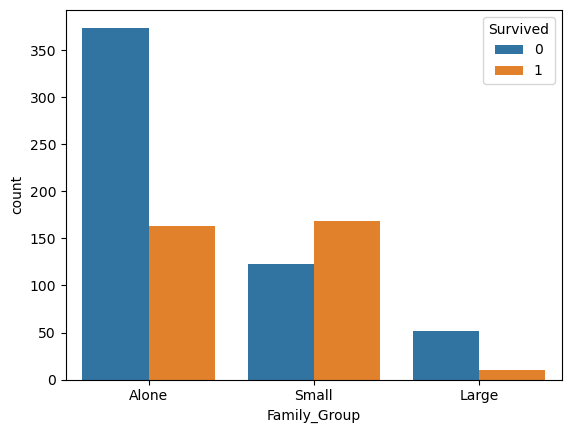

In [43]:
# 가족의 수 컬럼 이용해서 생존/사망 시각화
sns.countplot(data = train, x = 'Family_Group', hue = 'Survived')
plt.show()

In [44]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Family_Size,Family_Group
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,M,2,Small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,2,Small
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,M,1,Alone
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,C,2,Small
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,M,1,Alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,S,M,1,Alone
888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,S,B,1,Alone
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21,1,2,W./C. 6607,23.4500,S,M,4,Small


#### 불필요한 컬럼 삭제
 - .drop(), 삭제할 이름이 있는 방향으로 axis(= 1) 를 설정
 - 전처리 대상에서 제외되거나 전처리 후 불필요한 컬럼 삭제
 - Ticket, Name, Family_Size 삭제
 - train, test 삭제 적용!

In [45]:
# train.drop()
train.drop(['Ticket', 'Name', 'Family_Size'], axis = 1, inplace = True)
test.drop(['Ticket', 'Name', 'Family_Size'], axis = 1, inplace = True)

train.info() # 10개
test.info() # 9개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age           891 non-null    int64   
 4   SibSp         891 non-null    int64   
 5   Parch         891 non-null    int64   
 6   Fare          891 non-null    float64 
 7   Embarked      891 non-null    object  
 8   Deck          891 non-null    object  
 9   Family_Group  891 non-null    category
dtypes: category(1), float64(1), int64(5), object(3)
memory usage: 102.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    object  
 2   Ag

#### 문제, 답 데이터로 분리

In [46]:
# 훈련문제, 훈련답
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']

# 테스트문제
X_test = test

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        891 non-null    int64   
 1   Sex           891 non-null    object  
 2   Age           891 non-null    int64   
 3   SibSp         891 non-null    int64   
 4   Parch         891 non-null    int64   
 5   Fare          891 non-null    float64 
 6   Embarked      891 non-null    object  
 7   Deck          891 non-null    object  
 8   Family_Group  891 non-null    category
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 95.9+ KB


In [48]:
# 범주 -> 수치(원핫인코딩)
# 인코딩해야하는 컬럼 찾기
# 데이터의 타입에 대한 질문으로 불리언 인덱싱 활용해보기
cat_filter = (X_train.dtypes != 'int64') & (X_train.dtypes != 'float64')
cat_choice = X_train.columns[cat_filter]
cat_choice

Index(['Sex', 'Embarked', 'Deck', 'Family_Group'], dtype='object')

In [49]:
# 원핫인코딩 함수 -> pd.get_dummies(대상)
X_train_ch_oh = pd.get_dummies(X_train[cat_choice])
# X_test 적용
X_test_ch_oh = pd.get_dummies(X_test[cat_choice])

# X_train 과 원핫인코딩 데이터 합치기(병합하기)
X_train = pd.concat([X_train, X_train_ch_oh], axis = 1)
X_test = pd.concat([X_test, X_test_ch_oh], axis = 1)

# cat_choice 컬럼 삭제하기
X_train.drop(cat_choice, axis = 1, inplace = True)
X_test.drop(cat_choice, axis = 1, inplace = True)

In [50]:
X_train.shape, X_test.shape
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              891 non-null    int64  
 1   Age                 891 non-null    int64  
 2   SibSp               891 non-null    int64  
 3   Parch               891 non-null    int64  
 4   Fare                891 non-null    float64
 5   Sex_female          891 non-null    uint8  
 6   Sex_male            891 non-null    uint8  
 7   Embarked_C          891 non-null    uint8  
 8   Embarked_Q          891 non-null    uint8  
 9   Embarked_S          891 non-null    uint8  
 10  Deck_A              891 non-null    uint8  
 11  Deck_B              891 non-null    uint8  
 12  Deck_C              891 non-null    uint8  
 13  Deck_D              891 non-null    uint8  
 14  Deck_E              891 non-null    uint8  
 15  Deck_F              891 non-null    uint8  
 16  Deck_G  

In [51]:
# set() 자료형
# 집합
# 합집합, 차집합, 교집합
# 중복x, 순서x
# 중복을 허용하지 않는 set특징은 자료형의 중복을 제거하기 위한 필터 역할로 종종 사용된다
# 요소의 여부를 확인하기 위해서도 종종 사용
# 인덱싱 하고싶으면 리스트나 튜플로 형변환해서 사용해야함
set(X_train.columns) - set(X_test.columns)

{'Deck_T'}

In [55]:
# list(set(X_train.columns))
X_train['Deck_T'] 
# 'Deck_T'란 컬럼의 PassengerId는 원래 없는것

PassengerId
1      0
2      0
3      0
4      0
5      0
      ..
887    0
888    0
889    0
890    0
891    0
Name: Deck_T, Length: 891, dtype: uint8

In [57]:
# 'Deck_T' 컬럼을 추가하자
X_test['Deck_T'] = 0
X_test.shape

(418, 22)

In [61]:
# 컬럼의 종류는 맞추었지만 컬럼의 배치 순서가 다르다
display(X_train.columns)
display(X_test.columns)

# X_test 컬럼 순서를 X_train 컬럼 순서대로 맞추기
X_test = X_test[X_train.columns]
display(X_test.columns)
# Deck_T가 중간으로 순서가 잘 맞춰진 것을 볼 수 있다

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T',
       'Family_Group_Alone', 'Family_Group_Small', 'Family_Group_Large'],
      dtype='object')

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_Group_Alone',
       'Family_Group_Small', 'Family_Group_Large', 'Deck_T'],
      dtype='object')

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T',
       'Family_Group_Alone', 'Family_Group_Small', 'Family_Group_Large'],
      dtype='object')

#### 모델링
 - 모델 선택 및 하이퍼 파라미터
 - 모델 학습
 - 모델 예측 및 평가 (kaggle에 업로드)

In [62]:
# tree분류
tree_model = DecisionTreeClassifier()

In [84]:
# 학습
tree_model.fit(X_train,y_train)

# 예측 pred 변수에 담아주기
pre = tree_model.predict(X_test)
pre

# 정확도 점수 확인하기 위해서 kaggle 제출
# 답안지 파일 불러오기
# 예측 결과 Survived 컬럼에 초기화
sub = pd.read_csv('./data/titanic/gender_submission.csv')
sub['Survived'] = pre
sub.to_csv('bjh_submission01.csv', index=False)

In [111]:
# tree model - 모델 깊이 조정(하이퍼 파라미터 튜닝 과정)
tree_model = DecisionTreeClassifier(max_depth = 5)

from sklearn.model_selection import cross_val_score
# result = cross_val_score(모델, 문제, 답, cv=5)
result = cross_val_score(tree_model, X_train, y_train, cv=5)
print(result.mean())

# 추후 max_depth, min_samples_split, max_leaf_nodes, min_samples_leaf
# 어떤 파라미터 값의 조합이 좋을지 찾아주는 방법을 연결해볼 수 있음(그리드서치)
# max_depth : 5
# 설정한 모델의 예측값 kaggle 업로드하고 마무리

0.8069675475488042


In [112]:
# 학습
tree_model.fit(X_train,y_train)

# 예측 pred 변수에 담아주기
pre = tree_model.predict(X_test)
pre

# 정확도 점수 확인하기 위해서 kaggle 제출
# 답안지 파일 불러오기
# 예측 결과 Survived 컬럼에 초기화
sub = pd.read_csv('./data/titanic/gender_submission.csv')
sub['Survived'] = pre
sub.to_csv('bjh_submission02.csv', index=False)